# Analyze the article tags for 2022

In [465]:
from collections import Counter
from datetime import datetime
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")


## Load the data

In [436]:
conn = sqlite3.connect("news.db")
cursor = conn.cursor()
cursor.execute("SELECT timestamp, tags FROM Tagesschau")
results = cursor.fetchall()

In [437]:
df_news = pd.DataFrame(results, columns=['timestamp', 'tags'])
df_news['timestamp'] = pd.to_datetime(df_news['timestamp'])
df_news.sort_values("timestamp", inplace=True)

In [438]:
df_news

,timestamp,tags
25,2022-01-01 02:48:00,"Silvester,2021,Neujahr"
24,2022-01-01 03:07:00,"G7,Russland,China,Klima,Coronavirus"
23,2022-01-01 03:59:00,"Kulturhauptstadt,Kultur,Serbien"
22,2022-01-01 04:01:00,"Ipcioglu,Vierschanzentournee,Skispringen"
21,2022-01-01 07:14:00,"USA,New York,Eric Adams"
...,...,...
15719,2022-12-31 17:22:00,"Papst Benedikt XVI.,Vatikan,Papst"
15718,2022-12-31 18:21:00,"Ukraine,Angriffe,Russland,Kiew"
15717,2022-12-31 19:16:00,"Papst Benedikt XVI.,Reaktionen"
15716,2022-12-31 20:31:00,"Ukraine,Selenskyj,Russland"


## Simple exploratory data analysis on tags

### Article frequency
* How many articles are published in 2022?
* How are the articles distributed throughout the years?
* Are there months where more articles are published than usual?

In [530]:
df_articles_per_year = df_news.groupby(pd.Grouper(key="timestamp", freq="1Y")).agg({'tags': 'count'}).rename(columns={'tags': 'number of articles per year'})
df_articles_per_month = df_news.groupby(pd.Grouper(key="timestamp", freq="1M")).agg({'tags': 'count'}).rename(columns={'tags': 'number of articles per month'})
df_articles_per_week = df_news.groupby(pd.Grouper(key="timestamp", freq="1W")).agg({'tags': 'count'}).rename(columns={'tags': 'number of articles per week'})

print(df_articles_per_year)

            number of articles per year
timestamp                              
2022-12-31                        15746


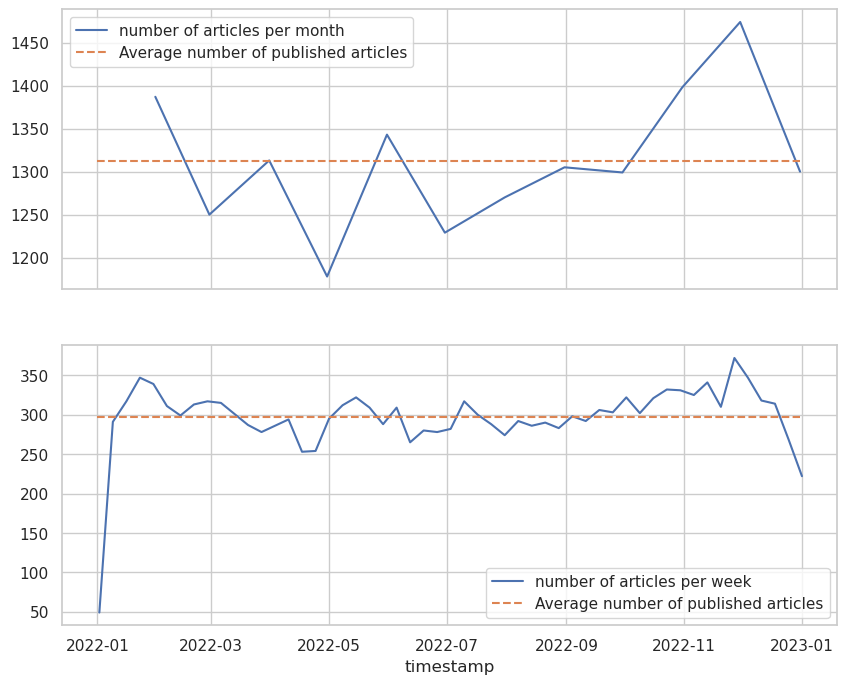

In [531]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=1, sharex=True)
# articles per month
sns.lineplot(
    data=df_articles_per_month, color='C0', ax=ax[0])
ax[0].hlines(y=df_articles_per_month.mean(), xmin=datetime(2022,1,1), xmax=datetime(2022,12,31), colors='C1', label='Average number of published articles', linestyles='dashed')
ax[0].legend()

# articles per week
sns.lineplot(
    data=df_articles_per_week, color='C0', ax=ax[1])
ax[1].hlines(y=df_articles_per_week.mean(), xmin=datetime(2022,1,1), xmax=datetime(2022,12,31), colors='C1', label='Average number of published articles', linestyles='dashed')
ax[1].legend()


### Tags
* What are the unique tags used in 2022?
* How many unique tags are used in 2022?
* What are the top tags used in 2022?
* What are the top tags used per month?
* How is the frequency of the top tags distributed over the year?
* How many tags are used per article?

In [538]:
df_news['tags_splitted'] = df_news['tags'].apply(lambda x: x.split(','))

In [539]:
df_news['tags_splitted']

25                         [Silvester, 2021, Neujahr]
24          [G7, Russland, China, Klima, Coronavirus]
23                [Kulturhauptstadt, Kultur, Serbien]
22       [Ipcioglu, Vierschanzentournee, Skispringen]
21                        [USA, New York, Eric Adams]
                             ...                     
15719           [Papst Benedikt XVI., Vatikan, Papst]
15718             [Ukraine, Angriffe, Russland, Kiew]
15717               [Papst Benedikt XVI., Reaktionen]
15716                  [Ukraine, Selenskyj, Russland]
15715                             [Ukraine, Liveblog]
Name: tags_splitted, Length: 15746, dtype: object

In [541]:
# How many tags are used per article?
df_news['num_tags'] = df_news['tags_splitted'].apply(len)

<AxesSubplot:xlabel='num_tags', ylabel='count'>

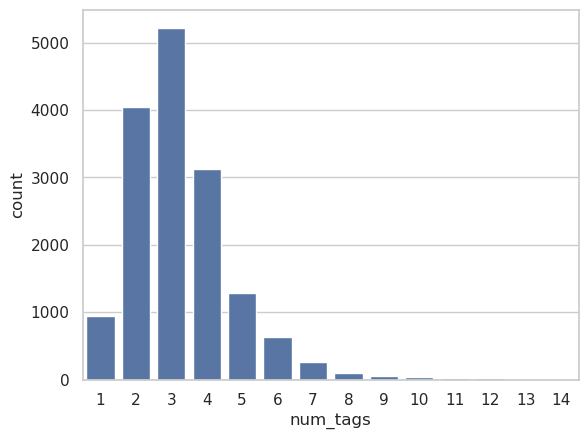

In [559]:
# plot distribution for number of tags per article
fig, ax = plt.subplots()
sns.countplot(data=df_news, x='num_tags', color='C0', ax=ax)

In [561]:

all_tags = []
for tags in df_news['tags_splitted']:
    all_tags.extend(tags)

In [566]:
# What are the unique tags used in 2022?
unique_tags = sorted(list(set(all_tags)))
print("The first 10 tags: ", unique_tags[:11])

# How many unique tags are used in 2022?
print(f"The number of unique tags in 2022: {len(unique_tags)}")

The first 10 tags:  ['', '"Blauer Kompass"', '"Cold Response"', '"Der Pate"', '"Fridays for Future"', '"Fujian"', '"Hubble"', '"Humanity 1"', '"New York Times"', '"Ocean Viking"', '"Offline"']
The number of unique tags in 2022: 9071


In [568]:
# What are the top tags used in 2022?
from collections import Counter
# https://note.nkmk.me/en/python-collections-counter/
tags_count_per_year = Counter(all_tags)

In [580]:
# What are the top tags used per month?
df_tags_per_month = df_news.groupby(pd.Grouper(key="timestamp", freq="1M")).agg({'tags_splitted': 'sum'}).rename(columns={'tags_splitted': 'all tags'})
df_tags_per_month['tags frequency'] = df_tags_per_month['all tags'].apply(Counter)
top_n = 10
df_tags_per_month['most frequently used tags'] = df_tags_per_month['tags frequency'].apply(lambda c: c.most_common(top_n))

In [586]:
df_tags_per_month

,all tags,tags frequency,most frequently used tags
timestamp,,,
2022-01-31,"[Silvester, 2021, Neujahr, G7, Russland, China...","{'Silvester': 5, '2021': 6, 'Neujahr': 3, 'G7'...","[(Coronavirus, 274), (Ukraine, 99), (Russland,..."
2022-02-28,"[Coronavirus, Impfnachweis, Booster-Impfung, G...","{'Coronavirus': 201, 'Impfnachweis': 2, 'Boost...","[(Ukraine, 273), (Russland, 235), (Coronavirus..."
2022-03-31,"[UN, Russland, USA, Energie, Russland, Europa,...","{'UN': 10, 'Russland': 327, 'USA': 45, 'Energi...","[(Ukraine, 495), (Russland, 327), (Ukraine-Kri..."
2022-04-30,"[Griechenland, Ukraine-Krieg, Migration, Flüch...","{'Griechenland': 3, 'Ukraine-Krieg': 84, 'Migr...","[(Ukraine, 410), (Russland, 185), (Coronavirus..."
2022-05-31,"[Liveblog, Ukraine, Ukraine, Scholz, Coronavir...","{'Liveblog': 30, 'Ukraine': 315, 'Scholz': 33,...","[(Ukraine, 315), (Russland, 128), (Coronavirus..."
2022-06-30,"[Zverev, French Open, Halbfinale, Alcaraz, Liv...","{'Zverev': 2, 'French Open': 3, 'Halbfinale': ...","[(Ukraine, 179), (Russland, 81), (Coronavirus,..."
2022-07-31,"[Deutsche Welle, Türkei, Coronavirus, Sachvers...","{'Deutsche Welle': 2, 'Türkei': 16, 'Coronavir...","[(Ukraine, 142), (Russland, 81), (Coronavirus,..."
2022-08-31,"[Kosovo, Spannungen, StarTrek, RIP, Nichols, U...","{'Kosovo': 6, 'Spannungen': 3, 'StarTrek': 1, ...","[(Ukraine, 144), (Energiekrise, 100), (Russlan..."
2022-09-30,"[Äthiopien, Tigray, Eritrea, Energie, Energiek...","{'Äthiopien': 2, 'Tigray': 2, 'Eritrea': 1, 'E...","[(Ukraine, 177), (Energiekrise, 157), (Russlan..."


<AxesSubplot:xlabel='count', ylabel='tag'>

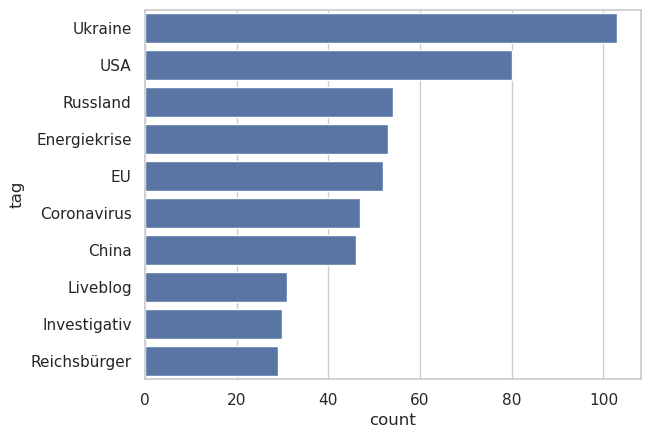

In [605]:
# How are the top tags distributed over the year?
sns.barplot(
    data=pd.DataFrame(df_tags_per_month.iloc[11]["most frequently used tags"], columns=['tag', 'count']),
    y='tag',
    x='count',
    color='C0'
)

<AxesSubplot:xlabel='count', ylabel='tag'>

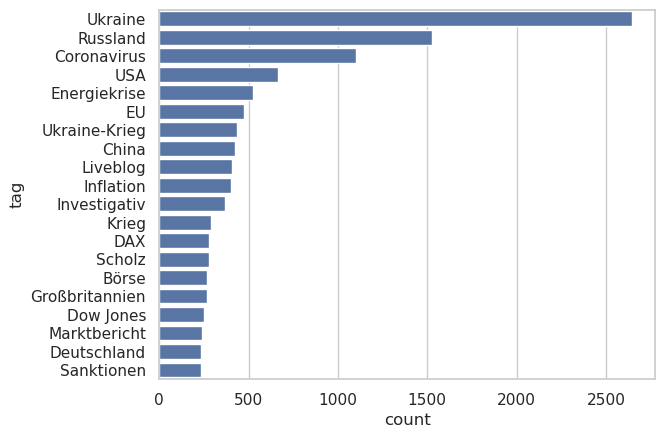

In [652]:
top_n_overall = 20
df_top_n_tags = pd.DataFrame(tags_count_per_year.most_common(top_n_overall), columns=['tag', 'count'])
sns.barplot(
    data=df_top_n_tags,
    y='tag',
    x='count',
    color='C0'
)

In [691]:
# Temporal distribution of tag occurrence 
df_tags_occurrence = pd.DataFrame()
for tag in df_top_n_tags['tag']:
    df_tags_occurrence = pd.concat([
        df_tags_occurrence,
        df_news\
            .set_index('timestamp')['tags_splitted']\
            .apply(lambda x: 1 if tag in x else 0)\
            .groupby(pd.Grouper(freq="1W"))\
            .sum()\
            .rename(tag)
        ],axis=1
    )

In [692]:
df_tags_occurrence

,Ukraine,Russland,Coronavirus,USA,Energiekrise,EU,Ukraine-Krieg,China,Liveblog,Inflation,Investigativ,Krieg,DAX,Scholz,Börse,Großbritannien,Dow Jones,Marktbericht,Deutschland,Sanktionen
2022-01-02 00:00:00,1,1,10,2,0,5,0,1,2,1,0,0,0,0,0,0,0,0,1,0
2022-01-09 00:00:00,9,9,66,20,0,6,0,8,7,13,4,0,6,2,5,2,6,5,1,0
2022-01-16 00:00:00,16,22,65,12,0,8,0,9,7,3,5,0,5,2,5,6,5,5,1,2
2022-01-23 00:00:00,32,24,46,15,0,12,0,8,7,5,4,0,4,1,4,12,4,4,6,0
2022-01-30 00:00:00,36,28,78,20,0,8,0,11,7,1,7,0,5,0,4,6,5,4,2,0
2022-02-06 00:00:00,28,28,47,21,0,10,0,11,7,7,7,0,5,7,5,3,5,5,2,1
2022-02-13 00:00:00,27,20,73,14,0,10,0,6,7,8,5,0,8,9,7,5,7,7,1,1
2022-02-20 00:00:00,61,45,63,14,0,10,0,6,8,8,8,0,7,12,5,5,5,5,1,3
2022-02-27 00:00:00,137,120,25,13,0,24,4,6,12,5,10,36,5,7,0,2,2,0,8,22
2022-03-06 00:00:00,158,115,13,11,0,11,29,6,14,5,7,42,6,3,5,1,5,4,16,34


<AxesSubplot:>

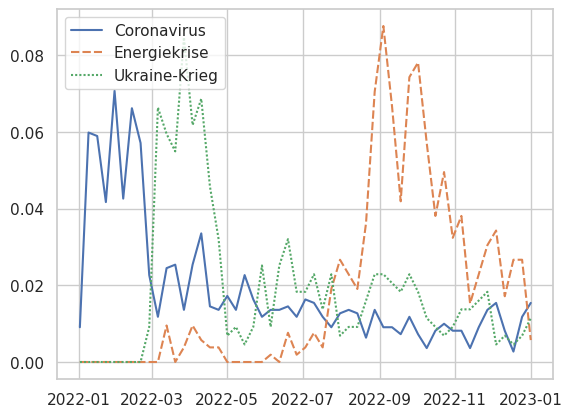

In [694]:
df_tags_rel_occurrence = df_tags_occurrence / df_tags_occurrence.sum()
sns.lineplot(data=df_tags_rel_occurrence[["Coronavirus", "Energiekrise", "Ukraine-Krieg"]])

Text(0.5, 1.0, 'Correlation heatmap')

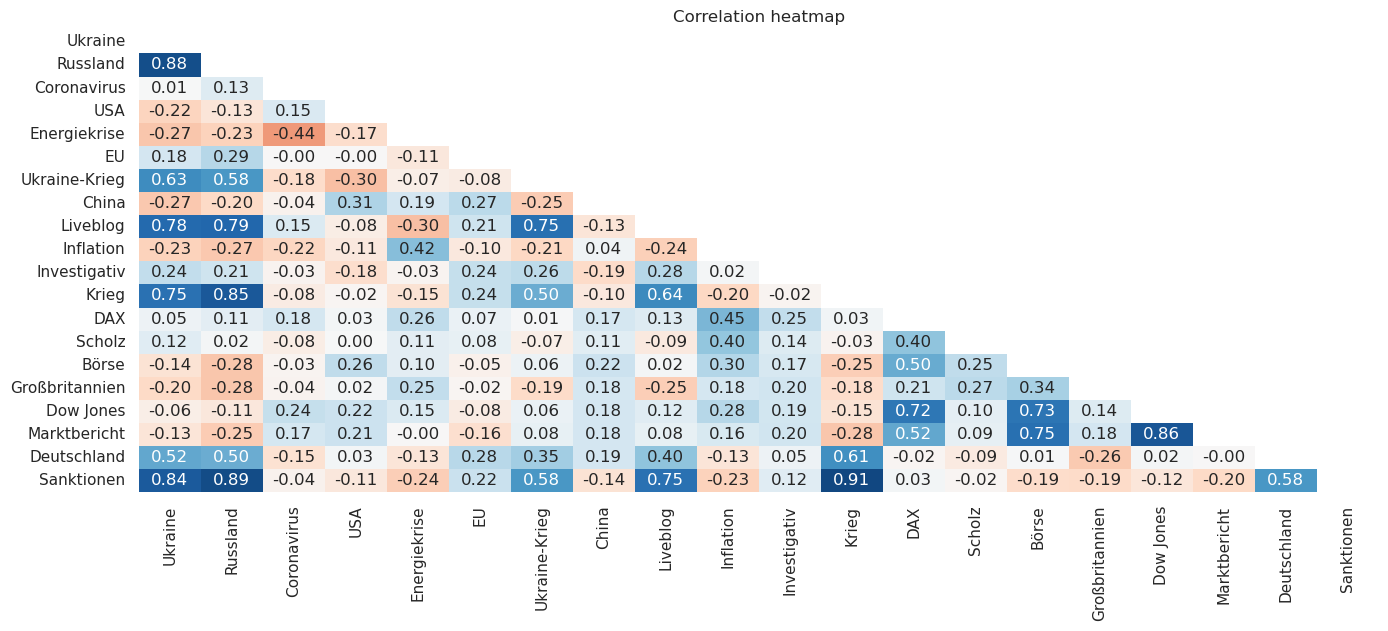

In [699]:
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
df_tag_correlation = df_tags_occurrence.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(df_tag_correlation, dtype=bool))
heatmap = sns.heatmap(df_tag_correlation, vmin=-1, vmax=1, annot=True, cmap='RdBu', mask=mask, cbar=False, fmt='.2f')
heatmap.set_title('Correlation heatmap')

## Topic modeling for tags

In [ ]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [ ]:
def custom_analyzer(comma_separated_tags):
    return [x.split(',') for x in comma_separated_tags]

In [ ]:
data_samples = df_news['tags'].apply(lambda x: x.split(',')).tolist()

In [ ]:
# create a dictionary for all tags used and assign integers to each tag
# all tags
all_tags = []
for tags_in_article in data_samples:
    all_tags.extend(tags_in_article)

In [ ]:
# What are the top tags used?

top_tags = df_tags_counts['tag'].values

In [ ]:
unique_tags = sorted(set(top_tags))
vocabulary = {key: value for key, value in zip(unique_tags, range(len(unique_tags)))}

tag_to_index = {key: value for key, value in zip(unique_tags, range(len(unique_tags)))}
index_to_tag = {key: value for key, value in enumerate(unique_tags)}

In [ ]:
# vectorize the article tags with the vocabulary mapping
# example:
# [['Corona', 'Liveblog'], ['Frankreich', 'Corona']] --> [[1, 2], [3, 1]]

test_input = ['Corona', 'Liveblog', 'Test']
test_output = [1, 2]
test_vocabulary = {'Corona': 1, 'Liveblog': 2, 'Frankreich': '3'}

def vectorize_tags(article_tags, vocabulary):
    return [vocabulary[tag] for tag in article_tags if tag in vocabulary]
    

In [ ]:
assert vectorize_tags(test_input, test_vocabulary) == test_output

In [ ]:
vectorized_tags = [vectorize_tags(article_tags, tag_to_index) for article_tags in data_samples]

In [ ]:
vectorized_tags

In [ ]:
test_input = [[1, 2, 4], [2, 3, 1], [5, 4, 1]]
test_vocabulary_id = [0, 1, 2, 3, 4, 5]

In [ ]:
import numpy as np

In [ ]:
# [1, 2, 4] -> [0, 1, 1, 0, 1, 0]
# [2, 3, 1] -> [0, 1, 1, 1, 0, 0]

# 1. get first id in doc
# 2. increment position with 1 in target vector
# 3. get next id in doc and do 2. again

def count_vectorize(doc_ids, vocabulary):
    num_docs = len(doc_ids)
    num_vocabulary_entities = len(vocabulary.values())
    vectors = np.zeros((num_docs, num_vocabulary_entities), dtype=int)
    for doc_count, doc in enumerate((doc_ids)):
        for id in doc:
            vectors[doc_count, id] += 1
    return vectors


In [ ]:
doc_ids_test = [[1, 2], [2, 3], [0], []]
vocabulary_test = {'a':0, 'b':1, 'c':2, 'd':3}

count_vectorize(doc_ids_test, vocabulary_test)

In [ ]:
count_vectorized = count_vectorize(vectorized_tags, tag_to_index)

In [ ]:
# get tfidf results
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfidf = TfidfTransformer()

In [ ]:
tfidf_vectorized = tfidf.fit_transform(count_vectorized)

In [ ]:
# Reduce dimensionality
from sklearn.decomposition import TruncatedSVD

In [ ]:
tsvd = TruncatedSVD(n_components=10)
tsvd.fit(tfidf_vectorized)

In [ ]:
tsvd.explained_variance_ratio_

In [ ]:
X_tsvd = tsvd.transform(tfidf_vectorized)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=5, max_iter=100, n_init=1)

In [ ]:
kmeans.fit(X_tsvd)

In [ ]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

In [ ]:
cluster_sizes

In [ ]:
[index_to_tag[index] for index in tsvd.inverse_transform(kmeans.cluster_centers_).argsort()[:, ::-1][4]]

In [ ]:
kmeans.cluster_centers_

In [ ]:
lda = LatentDirichletAllocation()
lda.fit(count_vectorized)

In [ ]:
lda.transform(vectorized_tfidf[-2:])

In [ ]:
lda.components_.shape

In [ ]:
topic = lda.components_[0]

In [ ]:
topic

In [ ]:
top_words = topic.argsort()[:-20:-1]

In [ ]:
[index_to_tag[index] for index in top_words]

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
# What tags are occurring together?

tag = 'Russland'

In [ ]:
# Give me all articles where I can find the tag
relevant_tags = []
for data_sample_ in data_samples:
    if tag in data_sample_:
        relevant_tags.append(data_sample_)
        

In [ ]:
df_relevant_tags_counts = pd.Series(flatten(relevant_tags)).value_counts().sort_values(ascending=False).reset_index()
df_relevant_tags_counts.columns = ['tag', 'count']

In [ ]:
df_relevant_tags_counts.head(10)

In [ ]:
from gensim import utils

In [ ]:
utils.simple_preprocess("This is a simple line")

In [ ]:
import gensim.models

In [ ]:
model = gensim.models.Word2Vec(sentences=data_samples, window=2, vector_size=100)

In [ ]:
model.wv['EU']

In [ ]:
all_tags_series.sample(1)

In [ ]:
print(model.wv.wmdistance(["USA"], ["Homeoffice"]))
print(model.wv.wmdistance(["USA"], ["Biden"]))
print(model.wv.wmdistance(["USA"], ["Ukraine"]))
print(model.wv.wmdistance(["Krieg"], ["Ukraine"]))
print(model.wv.wmdistance(["Krieg"], ["Mondmission"]))
print(model.wv.wmdistance(["Russland"], ["Putin"]))
print(model.wv.wmdistance(["Impfung"], ["Putin"]))

In [ ]:
print(model.wv.most_similar(["Landtagswahl"], topn=100))

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)